In [14]:
# basic
import os
import gc
import sys
import yaml
import warnings
import random
from pathlib import Path
from glob import glob
from tqdm import tqdm_notebook as tqdm
import hashlib
import pickle
warnings.filterwarnings('ignore')

# usual
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta

# preprocess
from fasttext import load_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
#import texthero as hero
import nltk
import collections
from gensim.models import word2vec, KeyedVectors
import cv2
import string
import re
import fasttext

# LightGBM
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb  # チューニング用

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pandas_profiling import ProfileReport  # profile report を作る用

# preprocessing
from sklearn.preprocessing import LabelEncoder

# plot settings
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams['font.family'] = 'sans_serif'
sns.set(style="whitegrid",  palette="muted", color_codes=True, rc={'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

# plot extentions
#import japanize_matplotlib
from matplotlib_venn import venn2

from tqdm import tqdm
tqdm.pandas()

In [15]:
# 試験ID生成
trial_prefix = 'nb019'  # ←手動で指定 
dttm_now = datetime.now().strftime('%Y%m%d_%H%M%S')
trial_id = f'{trial_prefix}_{dttm_now}'

print(trial_prefix)
print(trial_id)

nb019
nb019_20210602_082744


In [16]:
# アウトプットの出力先指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    OUTPUT_DIR = Path(".")
else:
    OUTPUT_DIR = Path(f"../03_outputs/{trial_prefix}")
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [17]:
# seed固定
def set_seed(seed=2021):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

SEED = 2021
set_seed(SEED)

In [18]:
# インプットフォルダ指定
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    DATA_DIR = '../input/commonlitreadabilityprize/'
else:
    DATA_DIR = '../00_input/commonlitreadabilityprize/'

In [19]:
# read_data
train_base = pd.read_csv(DATA_DIR + 'train.csv')
test_base = pd.read_csv(DATA_DIR + 'test.csv')
sample = pd.read_csv(DATA_DIR + 'sample_submission.csv')

## 特徴作成_共通処理

In [20]:
# ベースとなる継承元のクラス
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    def transform(self, input_df):
        raise NotImplementedError()

## テキスト特徴_共通処理

In [21]:
# ローカルの場合、stopwordsをダウンロード
import nltk
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    import nltk
    nltk.download('stopwords')
    nltk.download('averaged_perceptron_tagger')
    os.listdir(os.path.expanduser('~/nltk_data/corpora/stopwords/'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ktdogome/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
# テキスト前処理
# https://www.kaggle.com/alaasedeeq/commonlit-readability-eda

#filtering the unwanted symbols, spaces, ....etc
to_replace_by_space = re.compile('[/(){}\[\]|@,;]')
punctuation = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
bad_symbols = re.compile('[^0-9a-z #+_]')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_prepare(text):
    '''
    text: a string
    returna modified version of the string
    '''
    text = text.lower() # lowercase text
    text = re.sub(punctuation, '',text)
    text = re.sub(to_replace_by_space, " ", text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(bad_symbols, "", text)         # delete symbols which are in BAD_SYMBOLS_RE from text
    text = " ".join([word for word in text.split(" ") if word not in stopwords]) # delete stopwords from text
    text = re.sub(' +', ' ', text)
    return text


In [23]:
def text_normalization(s:pd.Series):
    x = s.apply(text_prepare)
    return x

# Counterオブジェクトを取得
def get_counter(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    counter = collections.Counter(text_list)
    return counter

## 品詞への変換

### 前処理

In [24]:
def get_pos_tag(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return pos_tag

def get_pos_tag_to_text(text:str):
    text_list = [wrd for wrd in text.split(" ") if wrd not in ('', '\n')]
    pos_tag = [i[1] for i in nltk.pos_tag(text_list)]
    return " ".join(pos_tag)

In [25]:
train_base['excerpt_pos'] = train_base['excerpt'].progress_map(get_pos_tag_to_text)
test_base['excerpt_pos'] = test_base['excerpt'].progress_map(get_pos_tag_to_text)

100%|██████████| 7/7 [00:00<00:00, 136.38it/s]


In [98]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfSimpleBlock(BaseBlock):
    """シンプルなTF-IDF特徴を作成する block"""
    def __init__(self, column: str, max_features=50, ngram_range=(1,1), use_idf=True):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.max_features=max_features
        self.ngram_range=ngram_range
        self.use_idf=use_idf

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.vectorizer_ = TfidfVectorizer(max_features=self.max_features
                                      ,ngram_range=self.ngram_range
                                      ,use_idf=self.use_idf)

        self.vectorizer_.fit(text)
        self.prefix = 'tfidf' if self.use_idf == True else 'tf'
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.vectorizer_.transform(text)

        out_df = pd.DataFrame(z.toarray())
        out_df.columns = self.vectorizer_.get_feature_names()
        return out_df.add_prefix(f'{self.prefix}_')


In [99]:
block = TfidfSimpleBlock('excerpt_pos', use_idf=False)
z = block.fit(train_base)

In [77]:
block = TfidfSimpleBlock('excerpt_pos', use_idf=False)
train_feat = pd.concat([train_base[['target']], block.fit(train_base, whole_df)], axis='columns')

In [81]:
train_feat.corr()

,target,tf_cc,tf_cd,tf_dt,tf_ex,tf_fw,tf_jj,tf_jjr,tf_jjs,tf_md,...,tf_uh,tf_vb,tf_vbd,tf_vbg,tf_vbn,tf_vbp,tf_vbz,tf_wdt,tf_wp,tf_wrb
target,1.000000,0.053580,-0.121292,-0.204476,0.038976,-0.013734,-0.180586,-0.014750,-0.020066,0.101747,...,0.016494,0.235662,0.319031,0.017071,-0.271823,0.111367,-0.112241,-0.193616,0.091363,0.185205
tf_cc,0.053580,1.000000,-0.091499,-0.181198,0.048007,-0.020732,0.029554,-0.022412,0.007844,-0.019094,...,-0.031610,0.040286,0.136194,-0.027812,-0.082926,-0.043016,-0.182943,-0.084679,0.006008,0.015429
tf_cd,-0.121292,-0.091499,1.000000,0.051290,0.024730,0.050625,0.017515,0.062856,0.079719,-0.104079,...,0.028921,-0.184636,-0.089785,-0.030370,0.096858,-0.005425,0.071843,0.020215,-0.085063,-0.090559
tf_dt,-0.204476,-0.181198,0.051290,1.000000,0.033451,-0.022765,-0.134372,0.004082,0.041180,-0.100325,...,-0.008516,-0.253911,-0.129723,-0.028354,0.152456,-0.163750,0.039807,0.132957,-0.080830,-0.095817
tf_ex,0.038976,0.048007,0.024730,0.033451,1.000000,0.007770,-0.006559,0.001011,0.004754,0.036004,...,0.012296,0.034751,0.028199,-0.030247,-0.039469,0.054915,0.012023,0.018421,0.025491,0.051099
tf_fw,-0.013734,-0.020732,0.050625,-0.022765,0.007770,1.000000,0.027546,0.016243,-0.041495,-0.023848,...,-0.005165,-0.009861,-0.003334,-0.015590,-0.018041,-0.001526,0.023873,-0.026596,-0.023944,0.010232
tf_jj,-0.180586,0.029554,0.017515,-0.134372,-0.006559,0.027546,1.000000,0.076240,0.039162,-0.024213,...,-0.019131,-0.090301,-0.341187,-0.010303,0.078153,0.185078,0.134896,0.147291,-0.081212,-0.074514
tf_jjr,-0.014750,-0.022412,0.062856,0.004082,0.001011,0.016243,0.076240,1.000000,0.052163,0.052628,...,0.022987,0.046222,-0.164549,0.027636,0.018673,0.106867,0.154985,0.057395,-0.019235,0.011817
tf_jjs,-0.020066,0.007844,0.079719,0.041180,0.004754,-0.041495,0.039162,0.052163,1.000000,-0.001657,...,-0.013565,-0.012541,-0.056506,-0.030216,0.031591,0.060946,0.016875,0.035957,-0.000643,-0.023255
tf_md,0.101747,-0.019094,-0.104079,-0.100325,0.036004,-0.023848,-0.024213,0.052628,-0.001657,1.000000,...,-0.001836,0.684072,-0.166809,-0.033143,-0.045270,0.138090,0.012404,-0.006860,0.081026,0.095154


In [88]:
block = TfidfSimpleBlock('excerpt_pos', ngram_range=(1,3), use_idf=False)
train_feat = pd.concat([train_base[['target']], block.fit(train_base, whole_df)], axis='columns')

In [89]:
train_feat.corr()

,target,tf_cc,tf_cc dt,tf_cd,tf_dt,tf_dt jj,tf_dt jj nn,tf_dt nn,tf_dt nn dt,tf_dt nn nn,...,tf_vbd dt,tf_vbd dt nn,tf_vbd prp,tf_vbd rb,tf_vbg,tf_vbn,tf_vbn dt,tf_vbp,tf_vbz,tf_wdt
target,1.000000,0.055719,-0.096887,-0.118583,-0.205529,-0.191297,-0.154407,-0.059707,-0.145369,-0.068939,...,0.258737,0.231701,0.219315,0.198555,0.020375,-0.265995,-0.257894,0.112865,-0.107504,-0.190253
tf_cc,0.055719,1.000000,0.354743,-0.079662,-0.186773,-0.088489,-0.122264,-0.172563,-0.212578,-0.101715,...,0.033075,0.012986,0.128118,0.102225,-0.014402,-0.068236,-0.103151,-0.019807,-0.165929,-0.074899
tf_cc dt,-0.096887,0.354743,1.000000,-0.027928,0.279629,0.146403,0.112322,0.142031,0.071323,0.031164,...,0.036492,0.015423,-0.032445,0.013155,-0.071267,0.010725,0.030934,-0.119288,-0.082817,-0.003488
tf_cd,-0.118583,-0.079662,-0.027928,1.000000,0.059707,0.023082,-0.030896,-0.103833,-0.023425,-0.040562,...,-0.047425,-0.069091,-0.131317,-0.080792,-0.024857,0.102664,0.074659,0.003721,0.077932,0.026071
tf_dt,-0.205529,-0.186773,0.279629,0.059707,1.000000,0.380871,0.278829,0.608659,0.558567,0.133913,...,0.114781,0.068698,-0.238415,-0.160198,-0.031407,0.151442,0.299058,-0.146044,0.039715,0.136437
tf_dt jj,-0.191297,-0.088489,0.146403,0.023082,0.380871,1.000000,0.821988,-0.135436,0.079352,-0.107228,...,0.013209,-0.134098,-0.155484,-0.079923,-0.019234,0.058762,0.162862,-0.121270,-0.016084,0.083995
tf_dt jj nn,-0.154407,-0.122264,0.112322,-0.030896,0.278829,0.821988,1.000000,-0.080883,0.075401,-0.073839,...,0.013655,-0.096083,-0.108769,-0.036748,-0.001083,0.026756,0.126499,-0.150695,0.002687,0.060907
tf_dt nn,-0.059707,-0.172563,0.142031,-0.103833,0.608659,-0.135436,-0.080883,1.000000,0.585931,0.348597,...,0.116181,0.275721,-0.049487,-0.067422,-0.005095,0.011786,0.163770,-0.165869,0.066023,0.041515
tf_dt nn dt,-0.145369,-0.212578,0.071323,-0.023425,0.558567,0.079352,0.075401,0.585931,1.000000,0.039964,...,-0.007269,0.051755,-0.103032,-0.092030,-0.036098,0.066421,0.187538,-0.147835,-0.002829,0.037614
tf_dt nn nn,-0.068939,-0.101715,0.031164,-0.040562,0.133913,-0.107228,-0.073839,0.348597,0.039964,1.000000,...,-0.020155,0.056528,-0.093066,-0.103199,-0.022682,-0.020569,0.030257,-0.029961,0.072766,0.032990


## テキスト特徴_gemsim

In [56]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1

class GensimPreTrainedBlock(BaseBlock):
    """
    文書をgemsim経由で学習済みモデルのベクトル表現へ変換するblock
    モデルは別途入手し、インスタンス作成時に指定する。
    モデル名は手動で入力する想定（デフォルトではgensim_pretrained で入る）
    """
    def __init__(self,
                 column: str,
                 model:KeyedVectors,
                 model_name='gensim_pretrained'):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model = model
        self.model_name = model_name

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
    
    # 文書ベクトルの取得
    def get_sentence_vector(self, model:KeyedVectors, x: str):
        ndim = model.vector_size
        embeddings = [
            model[word]
            if word in model
            else np.zeros(ndim)
            for word in x.split()
        ]

        if len(embeddings) == 0:
            return np.zeros(ndim, dtype=np.float32)
        else:
            return np.mean(embeddings, axis=0)

    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: self.get_sentence_vector(self.model, x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'{self.model_name}_{self.column}_')

## テキスト特徴_fasttest

In [57]:
# 参考: https://zenn.dev/koukyo1994/articles/9b1da2482d8ba1
class FasttextBlock(BaseBlock):
    """文書をfasttextのテキスト表現へ変換する block"""
    def __init__(self, column: str, ft_model:fasttext.FastText._FastText):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.ft_model = ft_model

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None):
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        feat = text.map(lambda x: ft_model.get_sentence_vector(x))
        out_df = pd.DataFrame(np.stack(feat.values))

        return out_df.add_prefix(f'fasttext_{self.column}_')

## テキスト特徴_統計量

In [58]:
class TextDescriptionBlock(BaseBlock):
    """テキストに関する統計量を返す block"""
    def __init__(self, column: str):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column

    # 前処理
    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x
        
    def fit(self, input_df, y=None, n_components=50):
        self.text = self.preprocess(input_df)
        self.counters = self.text.map(get_counter)
        return self.transform(input_df)

    def transform(self, input_df):
        _length = input_df[self.column].fillna('').map(lambda x: len(x) if x!='' else np.nan)
        _wrd_cnt = self.counters.map(lambda x: sum(x.values()))
        _wrd_nuniq = self.counters.map(lambda x: len(x))
        _wrd_mean = self.counters.map(lambda x: np.mean(list(x.values())))
        _wrd_max = self.counters.map(lambda x: np.max(list(x.values())))
        
        word_length = self.counters.map(lambda x: np.array([len(i) for i in x.keys()]))
        word_length_desc = word_length.map(lambda x: pd.Series(x.ravel()).describe())
        _word_length_desc_df = pd.DataFrame(word_length_desc.tolist()).iloc[:,1:]
        _word_length_desc_df = _word_length_desc_df.add_prefix('word_length_')
        
        out_df = pd.concat([_length, _wrd_cnt, _wrd_nuniq, _wrd_mean, _wrd_max], axis=1)
        out_df.columns = ['text_length', 'word_count', 'word_nunique', 'word_appearance_mean', 'word_appearance_max']
        out_df = pd.concat([out_df, _word_length_desc_df], axis=1)
        return out_df.add_suffix(f'_{self.column}')

## テキスト特徴_CountVectorizer

In [59]:
class CountVectorizerBlock(BaseBlock):
    """CountVectorizer x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1)):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', CountVectorizer(ngram_range=self.ngram_range)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'countvect_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_TF-IDF

In [26]:
# 参考: https://www.guruguru.science/competitions/16/discussions/556029f7-484d-40d4-ad6a-9d86337487e2/

class TfidfBlock(BaseBlock):
    """tfidf x SVD による圧縮を行なう block"""
    def __init__(self, column: str, n_components=50, ngram_range=(1,1), use_idf=True):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.n_components=n_components
        self.ngram_range=ngram_range
        self.use_idf=use_idf

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """tdidfを計算するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None, 
            y=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        self.pileline_ = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=100000
                                      ,ngram_range=self.ngram_range
                                      ,use_idf=self.use_idf)),
            ('svd', TruncatedSVD(n_components=self.n_components, random_state=SEED)),
        ])

        self.pileline_.fit(text)
        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        z = self.pileline_.transform(text)

        out_df = pd.DataFrame(z)
        return out_df.add_prefix(f'tfidf_{self.column}_{"_".join([str(i) for i in self.ngram_range])}_')


## テキスト特徴_W2V(データセットから学習)

In [61]:
# https://www.guruguru.science/competitions/16/discussions/2fafef06-5a26-4d33-b535-a94cc9549ac4/
# https://www.guruguru.science/competitions/16/discussions/4a6f5f84-8491-4324-ba69-dec49dc648cd/

def hashfxn(x):
    return int(hashlib.md5(str(x).encode()).hexdigest(), 16)

class W2VTrainBlock(BaseBlock):
    """Word2Vecを学習し、文書のベクトル表現を得るブロック。
       学習済みモデルを使うパターンは、別に作成するものとする。"""
    def __init__(self, 
                 column: str, 
                 model_size=50, 
                 min_count=1, 
                 window=5,
                 n_iter=100
                 ):
        """
        args:
            column: str
                変換対象のカラム名
        """
        self.column = column
        self.model_size=model_size
        self.min_count=min_count
        self.window=window
        self.n_iter=n_iter

    def preprocess(self, input_df):
        x = text_normalization(input_df[self.column])
        return x

    def get_master(self, _master_df):
        """Word2Vecを学習するための全体集合を返す."""
        return _master_df

    def fit(self, 
            input_df, 
            _master_df=None
           ):
        master_df = input_df if _master_df is None else self.get_master(_master_df)
        text = self.preprocess(master_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])
        self.w2v_model = word2vec.Word2Vec(word_lists.values.tolist(),
                                      vector_size=self.model_size,
                                      min_count=self.min_count,
                                      window=self.window,
                                      seed=SEED,
                                      workers=1,
                                      hashfxn=hashfxn,
                                      epochs=self.n_iter)

        return self.transform(input_df)

    def transform(self, input_df):
        text = self.preprocess(input_df)
        word_lists = text.map(lambda x: [i for i in x.split(' ') if i not in (' ')])

        # 各文章ごとにそれぞれの単語をベクトル表現に直し、平均をとって文章ベクトルにする
        sentence_vectors = word_lists.progress_apply(
            lambda x: np.mean([self.w2v_model.wv[e] for e in x], axis=0))
        sentence_vectors = np.vstack([x for x in sentence_vectors])
        sentence_vector_df = pd.DataFrame(sentence_vectors,
                                          columns=[f"w2v_{self.column}_w{self.window}_{i}"
                                                   for i in range(self.model_size)])
        
        return sentence_vector_df


# make_feat

In [94]:
# 初期化
train_feat = pd.DataFrame()
test_feat = pd.DataFrame()
train_target = train_base['target'].copy()

# tfidf作成用のdf作成
whole_df = pd.concat([train_base[['id', 'excerpt']], test_base[['id', 'excerpt']]], axis='rows')

In [100]:
# テキスト前処理
# 品詞変換カラムの作成
train_base['excerpt_pos'] = train_base['excerpt'].progress_map(get_pos_tag_to_text)
test_base['excerpt_pos'] = test_base['excerpt'].progress_map(get_pos_tag_to_text)
whole_df['excerpt_pos'] = whole_df['excerpt'].progress_map(get_pos_tag_to_text)

100%|██████████| 2841/2841 [00:18<00:00, 153.08it/s]


In [101]:
# 品詞変換
tfidf_pos_1_1 = TfidfSimpleBlock('excerpt_pos', use_idf=False)

In [102]:
# fit & trainの特徴作成
# 品詞変換
train_feat = pd.concat([train_feat, tfidf_pos_1_1.fit(train_base, whole_df)], axis='columns')

In [103]:
# testの特徴作成
# 品詞変換
test_feat = pd.concat([test_feat, tfidf_pos_1_1.transform(test_base)], axis='columns')

In [107]:
print(train_feat.shape)
train_feat.head()

(2834, 30)


,tf_cc,tf_cd,tf_dt,tf_ex,tf_fw,tf_jj,tf_jjr,tf_jjs,tf_md,tf_nn,...,tf_uh,tf_vb,tf_vbd,tf_vbg,tf_vbn,tf_vbp,tf_vbz,tf_wdt,tf_wp,tf_wrb
0,0.212286,0.077195,0.540363,0.000000,0.0,0.289480,0.0,0.0,0.019299,0.598259,...,0.0,0.038597,0.308779,0.038597,0.231584,0.038597,0.019299,0.038597,0.000000,0.019299
1,0.123508,0.000000,0.185262,0.000000,0.0,0.288185,0.0,0.0,0.061754,0.596956,...,0.0,0.267601,0.247016,0.041169,0.041169,0.164677,0.020585,0.020585,0.000000,0.041169
2,0.195283,0.021698,0.195283,0.021698,0.0,0.216982,0.0,0.0,0.000000,0.477359,...,0.0,0.086793,0.303774,0.021698,0.086793,0.086793,0.108491,0.000000,0.000000,0.000000
3,0.270281,0.054056,0.306319,0.000000,0.0,0.288300,0.0,0.0,0.000000,0.810844,...,0.0,0.072075,0.144150,0.000000,0.090094,0.054056,0.000000,0.018019,0.000000,0.000000
4,0.188579,0.056574,0.584594,0.018858,0.0,0.245152,0.0,0.0,0.000000,0.282868,...,0.0,0.075431,0.150863,0.000000,0.000000,0.000000,0.000000,0.000000,0.018858,0.000000


In [108]:
print(test_feat.shape)
test_feat.head()

(7, 30)


,tf_cc,tf_cd,tf_dt,tf_ex,tf_fw,tf_jj,tf_jjr,tf_jjs,tf_md,tf_nn,...,tf_uh,tf_vb,tf_vbd,tf_vbg,tf_vbn,tf_vbp,tf_vbz,tf_wdt,tf_wp,tf_wrb
0,0.089465,0.000000,0.447325,0.000000,0.0,0.290762,0.000000,0.000000,0.067099,0.738087,...,0.0,0.201296,0.156564,0.067099,0.000000,0.067099,0.044733,0.022366,0.000000,0.000000
1,0.187378,0.000000,0.416396,0.020820,0.0,0.249837,0.000000,0.000000,0.104099,0.478855,...,0.0,0.249837,0.395576,0.062459,0.041640,0.020820,0.000000,0.041640,0.000000,0.000000
2,0.224912,0.020447,0.306698,0.020447,0.0,0.245358,0.000000,0.000000,0.000000,0.552056,...,0.0,0.040893,0.327144,0.061340,0.040893,0.061340,0.040893,0.020447,0.020447,0.020447
3,0.072440,0.108661,0.325982,0.018110,0.0,0.289762,0.036220,0.000000,0.000000,0.796845,...,0.0,0.036220,0.000000,0.036220,0.162991,0.162991,0.162991,0.018110,0.000000,0.036220
4,0.172537,0.073945,0.295778,0.000000,0.0,0.320427,0.024648,0.024648,0.024648,0.616205,...,0.0,0.123241,0.098593,0.172537,0.147889,0.172537,0.123241,0.024648,0.000000,0.024648


In [109]:
print(train_feat.shape)
print(test_feat.shape)

(2834, 30)
(7, 30)


# train & predict

In [110]:
from sklearn.model_selection import KFold

def kfold_cv(X, y, n_splits=5, random_state=0):
    folds = KFold(n_splits=n_splits, random_state=0, shuffle=True)
    return list(folds.split(X, y))

In [111]:
target = 'target'
cv = kfold_cv(train_feat, train_target)

In [112]:
params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'seed': SEED
}

In [113]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [114]:
oof_preds = np.zeros(len(train_feat))
test_preds = np.zeros(len(test_feat))

importances = pd.DataFrame()
scores = []
models = []

for i, (train_index, valid_index) in enumerate(cv):
    print(f'\nFold {i + 1}')
    trn_x, trn_y = train_feat.iloc[train_index], train_target.iloc[train_index]
    val_x, val_y = train_feat.iloc[valid_index], train_target.iloc[valid_index]
    
    #dtrain = lgb.Dataset(trn_x, trn_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])
    #dvalid = lgb.Dataset(val_x, val_y, categorical_feature = ['LE_' + val_ for val_ in le_categories])

    dtrain = lgb.Dataset(trn_x, trn_y)
    dvalid = lgb.Dataset(val_x, val_y)

    model = lgb.train(
        params,
        train_set=dtrain,
        num_boost_round=100000,
        valid_sets=[dtrain, dvalid],
        valid_names=['training', 'valid'],
        early_stopping_rounds=20,
        verbose_eval=50
    )
    
    val_preds = model.predict(val_x)
    oof_preds[valid_index] = val_preds
    test_preds += model.predict(test_feat) / 5
    
    val_score = model.best_score['valid']['rmse']
    scores.append(val_score)
    models.append(model)
    
    imp_df = pd.DataFrame({
        'feature': model.feature_name(),
        'gain': model.feature_importance(importance_type='gain'),
        'fold': i+1
    })
    
    importances = pd.concat([importances, imp_df], axis=0)
    
mean_score = np.mean(scores)
std_score  = np.std(scores)
all_score  = np.sqrt(mean_squared_error(train_target, oof_preds))
metrics_name = 'RMSE'
print(f'Mean {metrics_name}: {mean_score}, std: {std_score}, All {metrics_name}: {all_score}')


Fold 1
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6256
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 28
[LightGBM] [Info] Start training from score -0.961023
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.53086	valid's rmse: 0.83727
Early stopping, best iteration is:
[36]	training's rmse: 0.597867	valid's rmse: 0.836338

Fold 2
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6252
[LightGBM] [Info] Number of data points in the train set: 2267, number of used features: 28
[LightGBM] [Info] Start training from score -0.946950
Training until validation scores don't improve for 20 rounds
[50]	training's rmse: 0.530801	

In [115]:
sample['target'] = test_preds

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    sample.to_csv('submission.csv',index=False)
else:
    sample.to_csv(OUTPUT_DIR/'submission.csv',index=False)

In [116]:
print(sample.shape)
sample.head()

(7, 2)


,id,target
0,c0f722661,-0.796266
1,f0953f0a5,-0.234910
2,0df072751,-0.635978
3,04caf4e0c,-1.527016
4,0e63f8bea,-0.976423


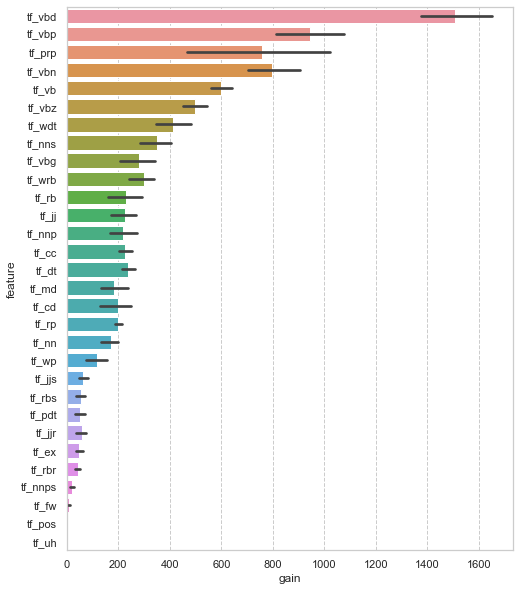

In [117]:
# importance(kaggle環境では描画しない)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    plt.figure(figsize=(8, 10))
    sns.barplot(x='gain', y='feature', data=importances.sort_values('gain', ascending=False));
    plt.savefig(os.path.join(OUTPUT_DIR, 'feature_importance.png'))

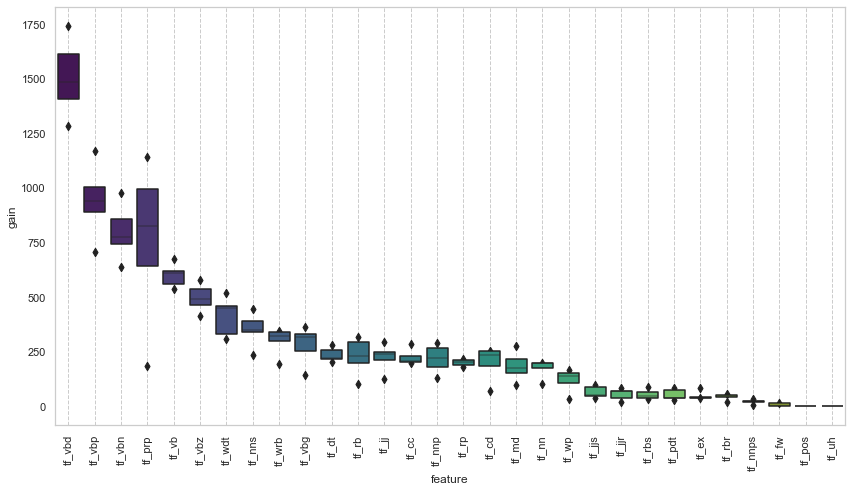

In [118]:
# importance_boxen(kaggle環境では描画しない)
# 参考: https://www.guruguru.science/competitions/13/discussions/d8f2d66a-aeee-4789-8b3d-d5935c26b1b7/

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    order = importances.groupby('feature')\
        .sum()[['gain']]\
        .sort_values('gain', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=importances, x='feature', y='gain', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    fig.savefig(os.path.join(OUTPUT_DIR, 'feature_importance_boxen.png'))

In [119]:
# SHAP(kaggle環境では描画しない)
# 参考その1: https://github.com/slundberg/shap/issues/337
# 参考その2: https://github.com/slundberg/shap/issues/630
import shap

if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap_values = []
    for model_ in models:
        explainer = shap.TreeExplainer(model_)
        shap_values.append(explainer.shap_values(train_feat))

    shap_mean = np.mean(shap_values, axis=0)

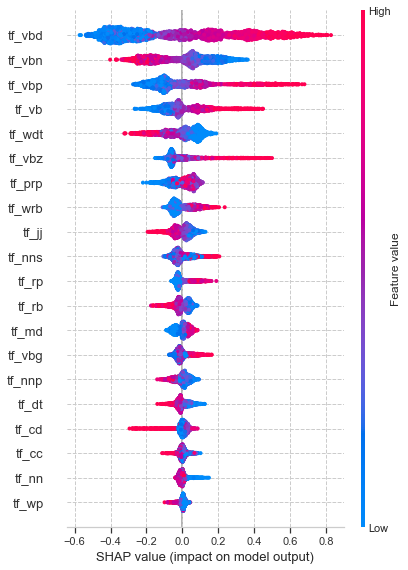

In [120]:
# SHAP_summary_plot
# 参考_画像の出力について: https://github.com/slundberg/shap/issues/153
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    shap.summary_plot(shap_mean, train_feat, show=False)
    plt.subplots_adjust(left=0.4, right=1.0)  # 保存画像のラベルが欠けるのを防ぐ
    plt.savefig(os.path.join(OUTPUT_DIR, 'shap_summary_plot.png'))

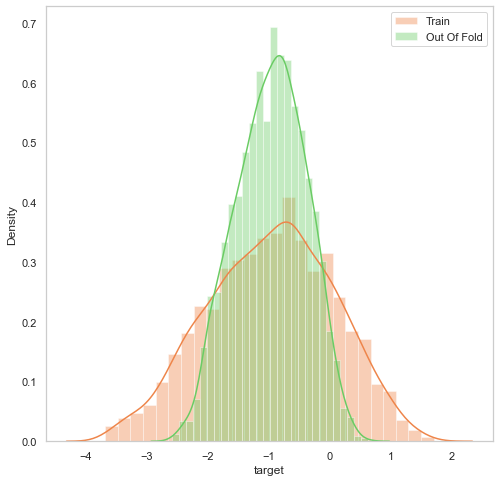

In [121]:
# 分布(train_vs_oof)
if 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass
else:
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.distplot(train_target, label='Train', ax=ax, color='C1')
    sns.distplot(oof_preds, label='Out Of Fold', ax=ax, color='C2')
    ax.legend()
    ax.grid()
    plt.savefig(os.path.join(OUTPUT_DIR, 'train_vs_oof.png'))